# **Part 1. Performance Prediction**

## **Import libraries**

In [1]:
import re
import requests
from lxml import etree

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
FONT_SIZE = 16
LABEL_SIZE = 14

plt.style.use('bmh')
plt.rcParams.update({'font.size': FONT_SIZE})
plt.rcParams.update({'xtick.labelsize': LABEL_SIZE})
plt.rcParams.update({'ytick.labelsize': LABEL_SIZE})
plt.rcParams.update({'legend.fontsize': LABEL_SIZE})

## **Parse data**

In [3]:
URL = 'https://www.top500.org/statistics/perfdevel/'

response = requests.get(URL)
root = etree.fromstring(response.text, parser=etree.HTMLParser())
text = root.xpath('//script[@type="text/javascript"]')[9].text

In [4]:
unit_mapping = {
    'GFlop/s': 1e9,
    'TFlop/s': 1e12,
    'PFlop/s': 1e15,
    'EFlop/s': 1e18,
}

dates = [x[1] for x in re.findall('("(\d{2}\/\d{4}): #1)', text)]

years = [int(x.split('/')[1]) for x in dates]

months = [int(x.split('/')[0]) for x in dates]

n1_flops = [float(x[0]) * unit_mapping[x[1]]
            for x in re.findall('#1 = (\d+\.\d+) (\w+\/s)', text)]

n500_flops = [float(x[0]) * unit_mapping[x[1]]
              for x in re.findall('#500 = (\d+\.\d+) (\w+\/s)', text)]

In [5]:
df = pd.DataFrame({'year': years,
                   'month': months,
                   'n1': n1_flops,
                   'n500': n500_flops})
df.head()

,year,month,n1,n500
0,1993,6,5.970000e+10,4.000000e+08
1,1993,11,1.240000e+11,5.000000e+08
2,1994,6,1.434000e+11,8.000000e+08
3,1994,11,1.700000e+11,1.200000e+09
4,1995,6,1.700000e+11,2.000000e+09


## **Fit/Predict**

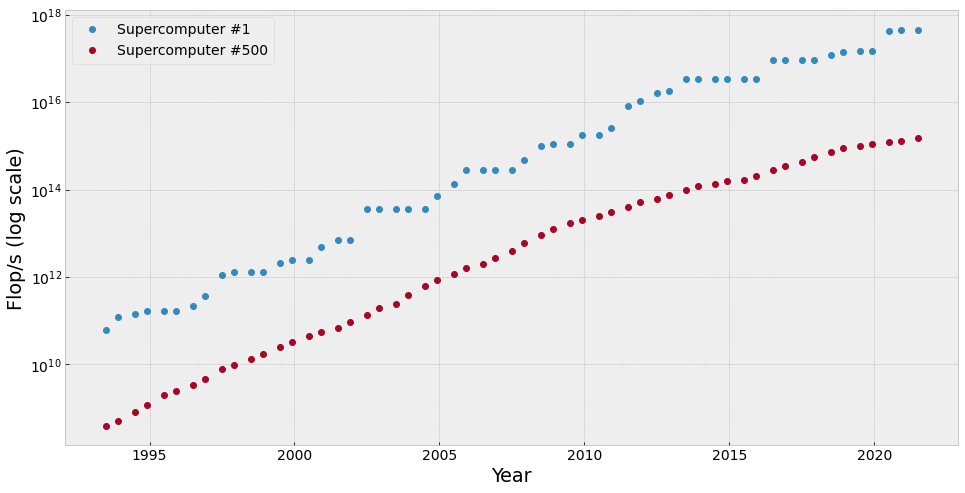

In [6]:
years = df.year + df.month / 12

plt.figure(figsize=(16, 8))
plt.xlabel('Year')
plt.ylabel('Flop/s (log scale)')
plt.plot(years, df.n1, 'o', label='Supercomputer #1')
plt.plot(years, df.n500, 'o', label='Supercomputer #500')
plt.legend()
plt.yscale('log')

По графикам изменения вычистительной мощности топ-1 и топ-500 суперкомпьютеров в логарифмическом формате видно, что зависимость может быть не совсем линейная, поэтому будем обучать коэффициенты полинома 2-й степени.

In [7]:
def date_to_months(df: pd.DataFrame, start_year: int, start_month: int):
    months = 12 * (df.year - start_year) + df.month - start_month
    return months


def months_to_date(months: int, start_year: int, start_month: int):
    months += start_month
    year, month = months // 12 + start_year, months % 12
    return year, month

In [8]:
start_year = df.year.min()
start_month = df[df.year == start_year].month.min()

df['months'] = date_to_months(df, start_year, start_month)
df.tail()

,year,month,n1,n500,months
52,2019,6,1.486000e+17,1.000000e+15,312
53,2019,11,1.486000e+17,1.100000e+15,317
54,2020,6,4.155000e+17,1.200000e+15,324
55,2020,11,4.420000e+17,1.300000e+15,329
56,2021,6,4.420000e+17,1.500000e+15,336


In [9]:
y_log_n1 = np.log(df.n1)
y_log_n500 = np.log(df.n500)

In [10]:
coefs_1 = np.polyfit(df.months, y_log_n1, deg=2)
coefs_500 = np.polyfit(df.months, y_log_n500, deg=2)

In [11]:
def get_y(x, coefs):
    y = np.asarray([
        sum((x_i ** power) * coef for power, coef in enumerate(coefs[::-1]))
        for x_i in x
    ])
    return y

In [12]:
def generate_test(df: pd.DataFrame, start_year: int, start_month: int,
                  last_year: int):
    while True:
        values = df.months.values
        months = values[-1] + values[-2] - values[-3]
        year, month = months_to_date(months, start_year, start_month)
        if year > last_year:
            break
        df = df.append({'year': year, 'month': month, 'months': months},
                       ignore_index=True)

    new_df = df[['year', 'month', 'months']]
    return new_df

In [13]:
df_test = generate_test(df, start_year, start_month, last_year=2025)
df_test.tail()

,year,month,months
61,2023.0,11.0,365.0
62,2024.0,6.0,372.0
63,2024.0,11.0,377.0
64,2025.0,6.0,384.0
65,2025.0,11.0,389.0


In [14]:
df_test['n1'] = np.exp(get_y(df_test.months, coefs_1))
df_test['n500'] = np.exp(get_y(df_test.months, coefs_500))

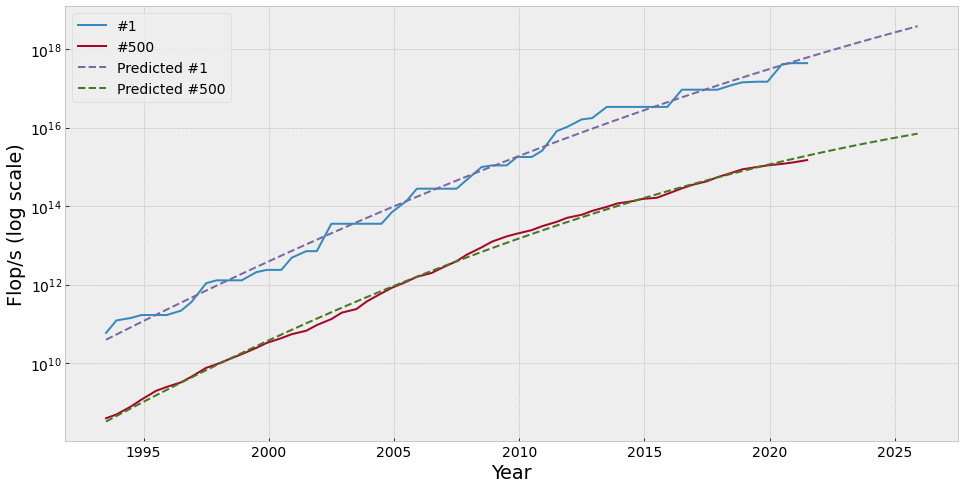

In [15]:
num_preds = len(df_test) - len(df)
years = df_test.year + df_test.month / 12

plt.figure(figsize=(16, 8))
plt.xlabel('Year')
plt.ylabel('Flop/s (log scale)')
plt.yscale("log")

plt.plot(years[:-num_preds], df.n1.values, label='#1')
plt.plot(years[:-num_preds], df.n500.values, label='#500')
plt.plot(years, df_test.n1, linestyle='--', label='Predicted #1')
plt.plot(years, df_test.n500, linestyle='--', label='Predicted #500')

plt.legend();

In [16]:
df_test.tail()

,year,month,months,n1,n500
61,2023.0,11.0,365.0,1.722476e+18,4.095866e+15
62,2024.0,6.0,372.0,2.188423e+18,4.833028e+15
63,2024.0,11.0,377.0,2.590737e+18,5.420994e+15
64,2025.0,6.0,384.0,3.270872e+18,6.335961e+15
65,2025.0,11.0,389.0,3.854785e+18,7.058544e+15


In [17]:
print(f'Top1 performance in 11/2025: ' \
      f'{df_test.n1.values[-1] / unit_mapping["EFlop/s"]:.2f} EFlop/s.')

Top1 performance in 11/2025: 3.85 EFlop/s.


In [18]:
print(f'Top500 performance in 11/2025: ' \
      f'{df_test.n500.values[-1] / unit_mapping["PFlop/s"]:.2f} PFlop/s.')

Top500 performance in 11/2025: 7.06 PFlop/s.


# **Part 2. Power Consumption**

In [19]:
URL = 'https://www.top500.org/lists/top500/list/2021/06/?page='

response = requests.get(URL + '1')
root = etree.fromstring(response.text, parser=etree.HTMLParser())

In [20]:
power_consumption_kwh = 0

for page_idx in range(1, 6):
    response = requests.get(URL + str(page_idx))
    root = etree.fromstring(response.text, parser=etree.HTMLParser())
    table = root.xpath('//table')[0]

    for x in table.iterchildren():
        values = list(x.iterfind('td'))
        if values:
            try:
                power_kwh = float(values[-1].text.replace(',', ''))
                power_consumption_kwh += power_kwh
            except:
                continue

print(f'Top-500 supercomputers total power consumption: ' \
      f'{power_consumption_kwh:.1f} kWh.')

Top-500 supercomputers total power consumption: 344004.0 kWh.


According to https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/pdfs/energy-economics/statistical-review/bp-stats-review-2021-full-report.pdf (page 63), total world energy production for year 2020 is 26823.2 TWh, which in kWh will be:

In [21]:
total_power_production_kwh = 26823.2 * 1e9

In [22]:
print(f'{power_consumption_kwh / total_power_production_kwh * 100:.9f}%')

0.000001282%
